# Run Analysis

This notebook analyze the information generated by the experiment I had for **m4 daily finance dataset**. There are two remarks to the configuration:

- log-return target transformation is applied after DC transformation
- Akima interpolation is used here
- I set the q parameter (number of past observations to take an average of) of Moving Average (MA) agent to 1. MA is hence a naive forecaster.
- There are two versions of MA, with and without log-difference transformation. The ordinary MA is with log-differencing, and MA(not log-diff) is the one without.

Other information about the run:

- a total of 50 time series are run
- models involved are MA(naive on raw data), MA(naive on log-differenced data), EN, MLP, RF, LGBM, ETS, and LSVR
- gap = 0
- horiozn = 1
- retrain window = 10

In [1]:
import os
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from pprint import pprint

plt.rcParams['figure.figsize'] = (20, 8)
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

Load run information

In [2]:
plt.style.use('ggplot')

In [3]:
runs = ['13-07-2022--18-20-12', '14-07-2022--10-28-15']

run_infos = []

for run in runs:
    with open(f'{run}/run_info.json', 'r') as file:
        run_infos.append(json.load(file))

pprint(run_infos)

[{'Avg. len of series': 1218.54,
  'config input': {'dataset': {'cumulate used': 0,
                               'file name': 'm4_daily_finance.json',
                               'file path': 'datasets/',
                               'file type': 'json',
                               'max length': 1500,
                               'min length': 1000,
                               'use series': 50},
                   'execution config': {'n of workers': 22},
                   'modelling config': {'forecast horizon': 1,
                                        'gap': 0,
                                        'retrain window': 10,
                                        'score measure': 'SMAPE',
                                        'test size': 0.1,
                                        'validation size': 0.1},
                   'models': ['MA', 'EN', 'MLP', 'LSVR', 'RF', 'LGBM', 'ETS'],
                   'transformation config': {'interp kind': ['akima'],
           

Load agents' run information

In [4]:
agent_infos_raw = {}
not_log_diff_count = 0
log_diff_count = 0

for i, run in enumerate(run_infos):
    run_id = run['run time'][0]
    models = run['config input']['models']
    
    if run_id == '14-07-2022--10-28-15':
        for m in models:
            agent_1 = f'{m}(not log-diff)_raw'
            agent_2 = f'{m}(not log-diff)_tran'

            if not_log_diff_count == 0:
                with open(f'{run_id}/MA_raw.json', 'r') as file:
                    agent_infos_raw[agent_1] = json.load(file)
                with open(f'{run_id}/MA_tran.json', 'r') as file:
                    agent_infos_raw[agent_2] = json.load(file)
            else:
                with open(f'{run_id}/MA_raw.json', 'r') as file:
                    agent_infos_raw[agent_1] = {**agent_infos_raw[agent_1], **json.load(file)}
                with open(f'{run_id}/MA_tran.json', 'r') as file:
                    agent_infos_raw[agent_2] = {**agent_infos_raw[agent_2], **json.load(file)}

        not_log_diff_count += 1
        continue

    for m in models:
        agent_1 = f'{m}_raw'
        agent_2 = f'{m}_tran'

        if log_diff_count == 0:
            with open(f'{run_id}/{agent_1}.json', 'r') as file:
                agent_infos_raw[agent_1] = json.load(file)
            with open(f'{run_id}/{agent_2}.json', 'r') as file:
                agent_infos_raw[agent_2] = json.load(file)
        else:
            with open(f'{run_id}/{agent_1}.json', 'r') as file:
                agent_infos_raw[agent_1] = {**agent_infos_raw[agent_1], **json.load(file)}
            with open(f'{run_id}/{agent_2}.json', 'r') as file:
                agent_infos_raw[agent_2] = {**agent_infos_raw[agent_2], **json.load(file)}
    log_diff_count += 1


In [5]:
agent_infos_raw = dict( sorted(agent_infos_raw.items(), key=lambda x: x[0].lower()) )

list(agent_infos_raw.keys())

['EN_raw',
 'EN_tran',
 'ETS_raw',
 'ETS_tran',
 'LGBM_raw',
 'LGBM_tran',
 'LSVR_raw',
 'LSVR_tran',
 'MA(not log-diff)_raw',
 'MA(not log-diff)_tran',
 'MA_raw',
 'MA_tran',
 'MLP_raw',
 'MLP_tran',
 'RF_raw',
 'RF_tran']

Check if all time series have been played successfully. Exclude those which not all agents have played successfully.

In [6]:
agent_fails = {k: [] for k in agent_infos_raw.keys()}
series_excluded = []

for agent, plays in agent_infos_raw.items():
    for series, info in plays.items():
        if info['message'] != None:
            agent_fails[agent].append(series)
            series_excluded.append(series)

if not series_excluded:
    print('All agents have successfully ran on all series.')
else:
    print(series_excluded)
    print(agent_fails)

All agents have successfully ran on all series.


Get analysis only on the series played by all agents.

In [7]:
played = [set(plays.keys()) for plays in agent_infos_raw.values()]
played_by_all = played[0].intersection(*played[1:])
print('Series played by all agents: ')
print(played_by_all)

Series played by all agents: 
{'2526', '2589', '2044', '2576', '2310', '2552', '2575', '2578', '2625', '2041', '2485', '2440', '2624', '2755', '2516', '2081', '2040', '2590', '2439', '2317', '2621', '2753', '2045', '2623', '2551', '2484', '2137', '2580', '2754', '2497', '2517', '2370', '2432', '2595', '2315', '2518', '2483', '2622', '2502', '2078', '2292', '2080', '2425', '2214', '2591', '2503', '2553', '2592', '2577', '2588'}


In [8]:
dict_filter = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ]) # large, filter keys

agent_infos = {agent: dict_filter(plays, played_by_all) for agent, plays in agent_infos_raw.items()}

## A glance at model prediction

Before digging into the details, take a quick look on how the models are doing on the tests. In this section, I manually took two time series that were played by all agents. One of the time series exhibits an exogeneous shock in the testing set.

In [9]:
# the time series
with open('m4_daily_finance_2.json', 'r') as file:
    ts = json.load(file)

print(ts.keys())

use = '2440'

dict_keys(['2040', '2440'])


In [10]:
# filter out the test set

test_size = run_infos[0]['config input']['modelling config']['test size']
test_set_count = int(len(ts[use]) * test_size)

test_set = ts[use][-(test_set_count):]

This is the naive forecaster without applying log-differencing. The graph shows that with or without DC transformation doesn't matter. And this is because when DC transformation hasn't identified a fully completed event, it returns the original datapoint. Given that the naive forecaster only takes into account the latest observation (in which there's extremely high probability no event has been identified during this datapoint), the agent turns out using the original datapoint as the input for its predictions all the time. This makes the DC transformation negligible, hence generating the exact same results as the one without DC transformation.

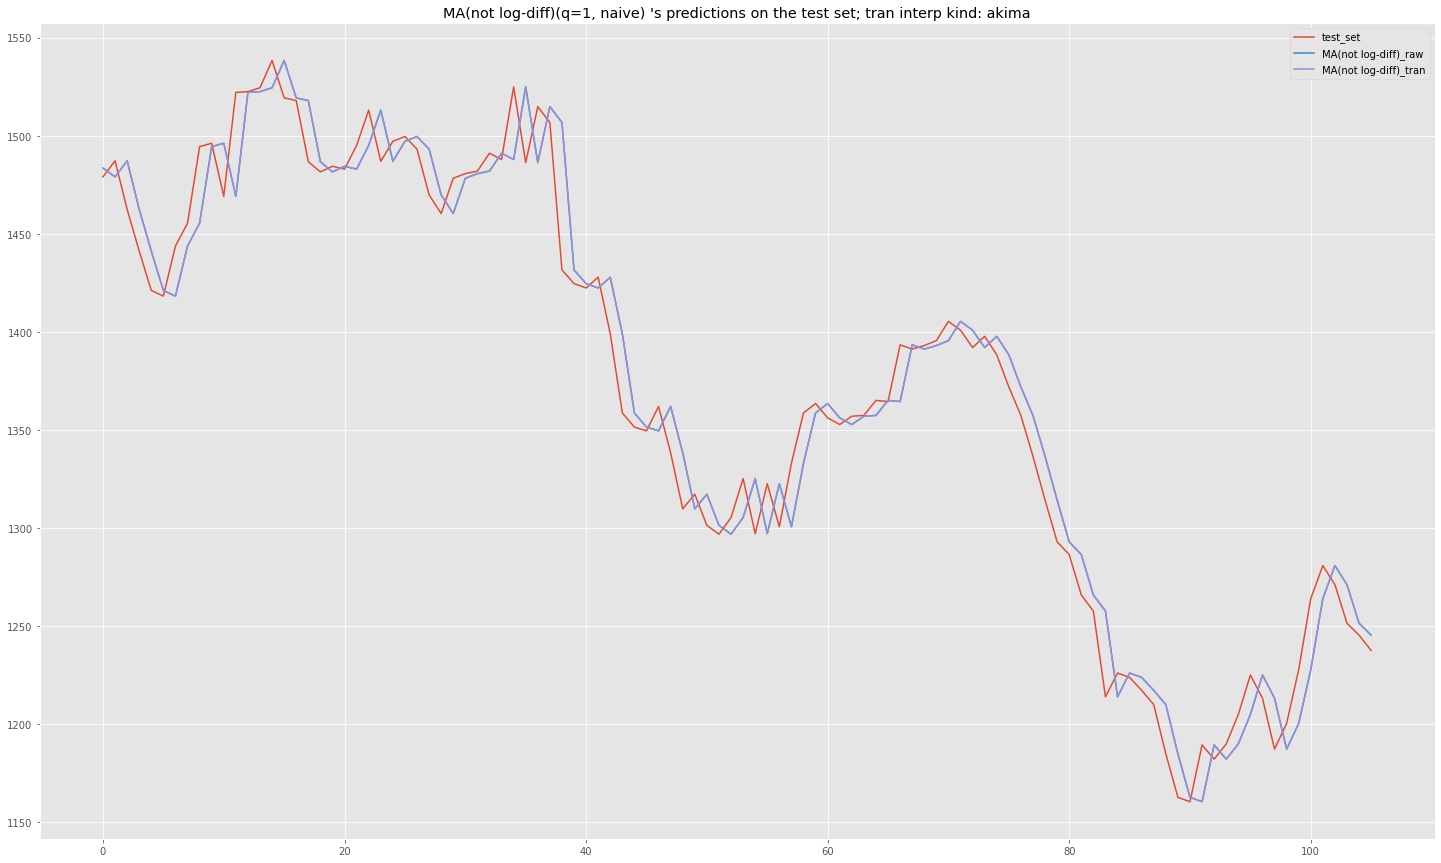

In [11]:
model = 'MA(not log-diff)'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}(q=1, naive) \'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

This is also a naive forecaster, but the different thing here is that it's a naive forecaster on the log-differenced series. The naive prediction on the log-differenced series (some value mostly lies between -1 and 1) is then back-transformed to the original scale (in this case, some value close to 1300). It's obvious that this version of naive forecaster doesn't give genuine 'naive' predictions. The reason being: for the agent to give the exact naive prediction, he has to produce 0 as the log-differenced prediction; 0 will then be back-transformed into the exact naive prediction in the original scale. However, we let the agent produce a navie prediction in the log-differenced scale, which is not going to be zero unless the latest observed log-return is 0.

The other remark of this graph is this: although he mostly does, the DC transformed agent doesn't always generate exact predictions as the one without DC. They only ever harbour different opinions for about 8 times out of around 110 test datapoints shown in this graph. The cycling effect of DC discussed earlier should always be present, with or without log-differencing. So the question here is: why is it given the cycling effect of DC discussed earlier, DC doesn't always produce the same prediction as the un-DCed agent?

The answer to this question is: the points where DC agent and un-DCed agent do not agree with each other is where an event is identified. Only in these scenarios, the DC agent has a different input value compared to the un-DCed agent due to the identified event. In particular, the log-difference of the latest observation is now not the same after the DC identified an event. This is what causes the DC agent to come up with a different prediction.

But wait, why is it the predictions in the non-log-differenced case (previous graph) are always the same? Simple, since DC doesn't really alter the original data point when the point is identified as some states, the naive forecaster in this case should be the same as the un-DC agent. Another way to put this is: DC performs transformation upon identifying a status from the original datapoint, and the transformation does not change the value of identified datapoint but its slope. This alteration is therefore shown when observing the log-differenced series but not the original series.

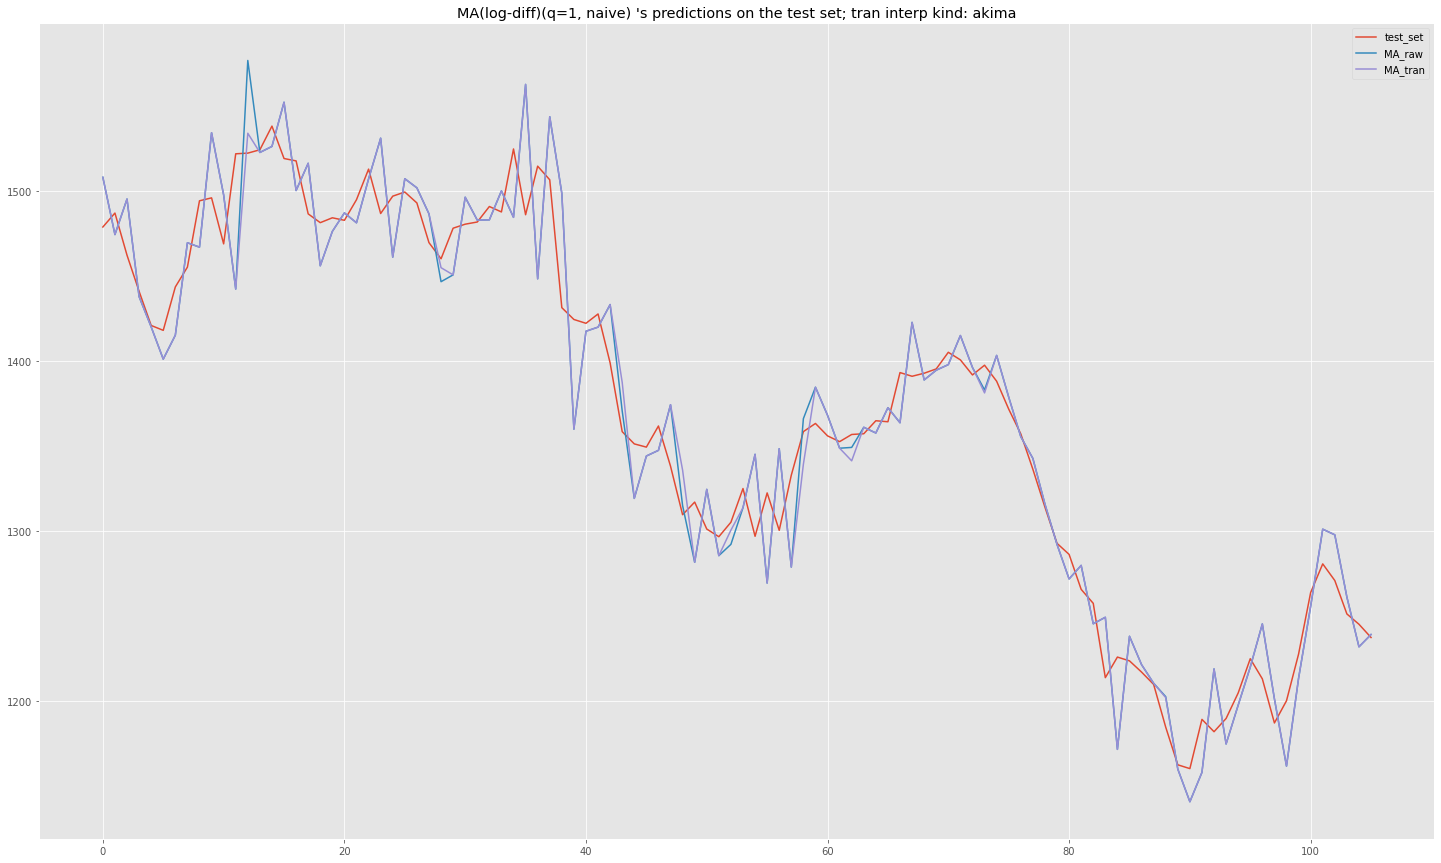

In [12]:
model = 'MA'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}(log-diff)(q=1, naive) \'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

In the case of an Elastic Net forecaster, the OLS estimator to the log-differenced series is simply 0. That's why the predictions turns out to be naive. And this holds for both log-differenced original series and log-differenced DC transformed series.

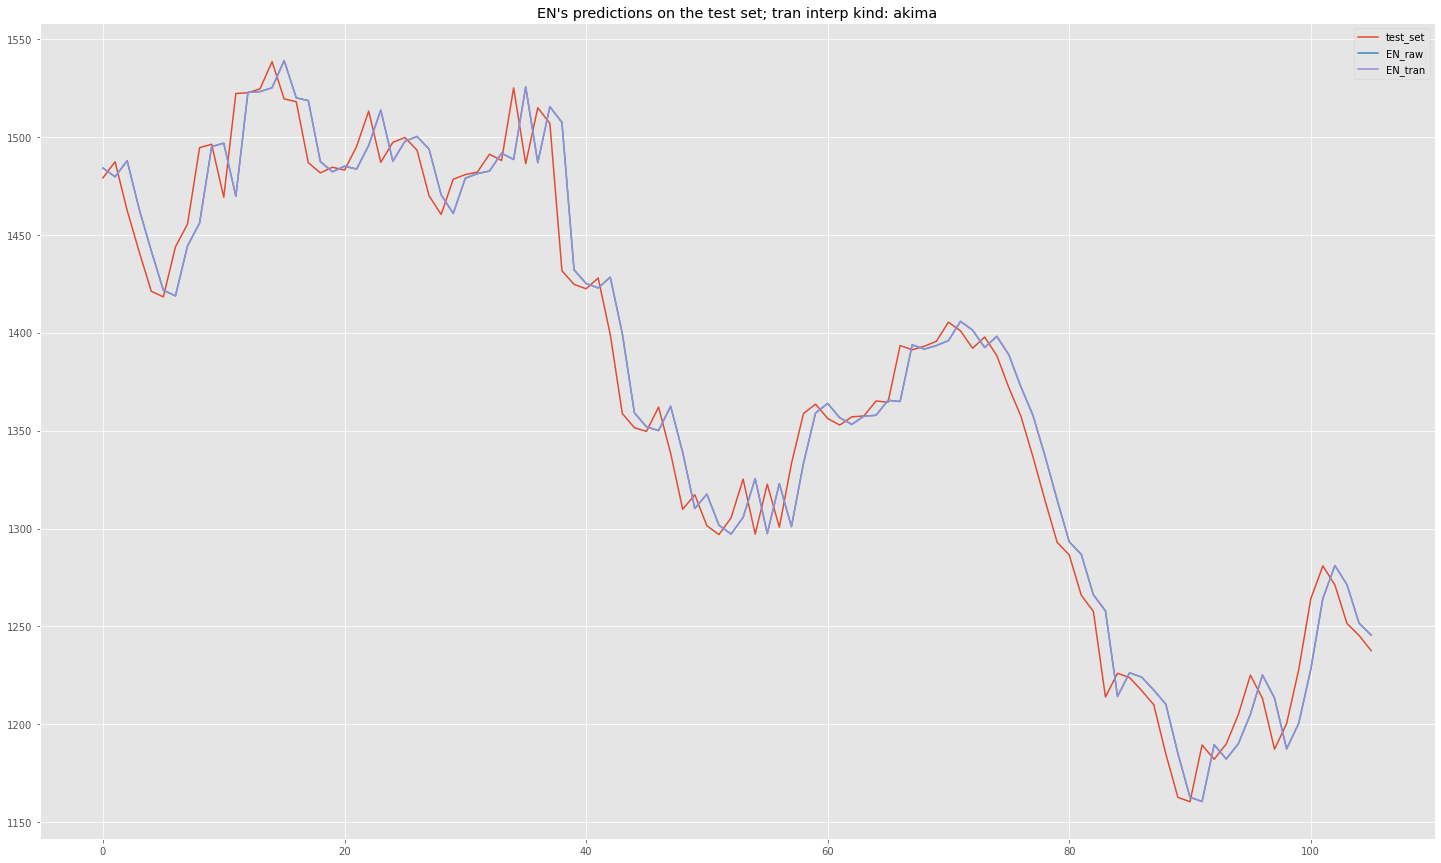

In [13]:
model = 'EN'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

For models that do not use a linear combination of the inputs as the prediction, they do not have the chance to produce naive forecasts. This is the reason why their predictions do not seem that naive-ish compared to what's shown in the previous graphs. Nevertheless, I'd say these models pretty much are mimicing the naive forecaster. From what is shown in the later sections, the fact that the naive forecaster generating a lower average error supports this claim.

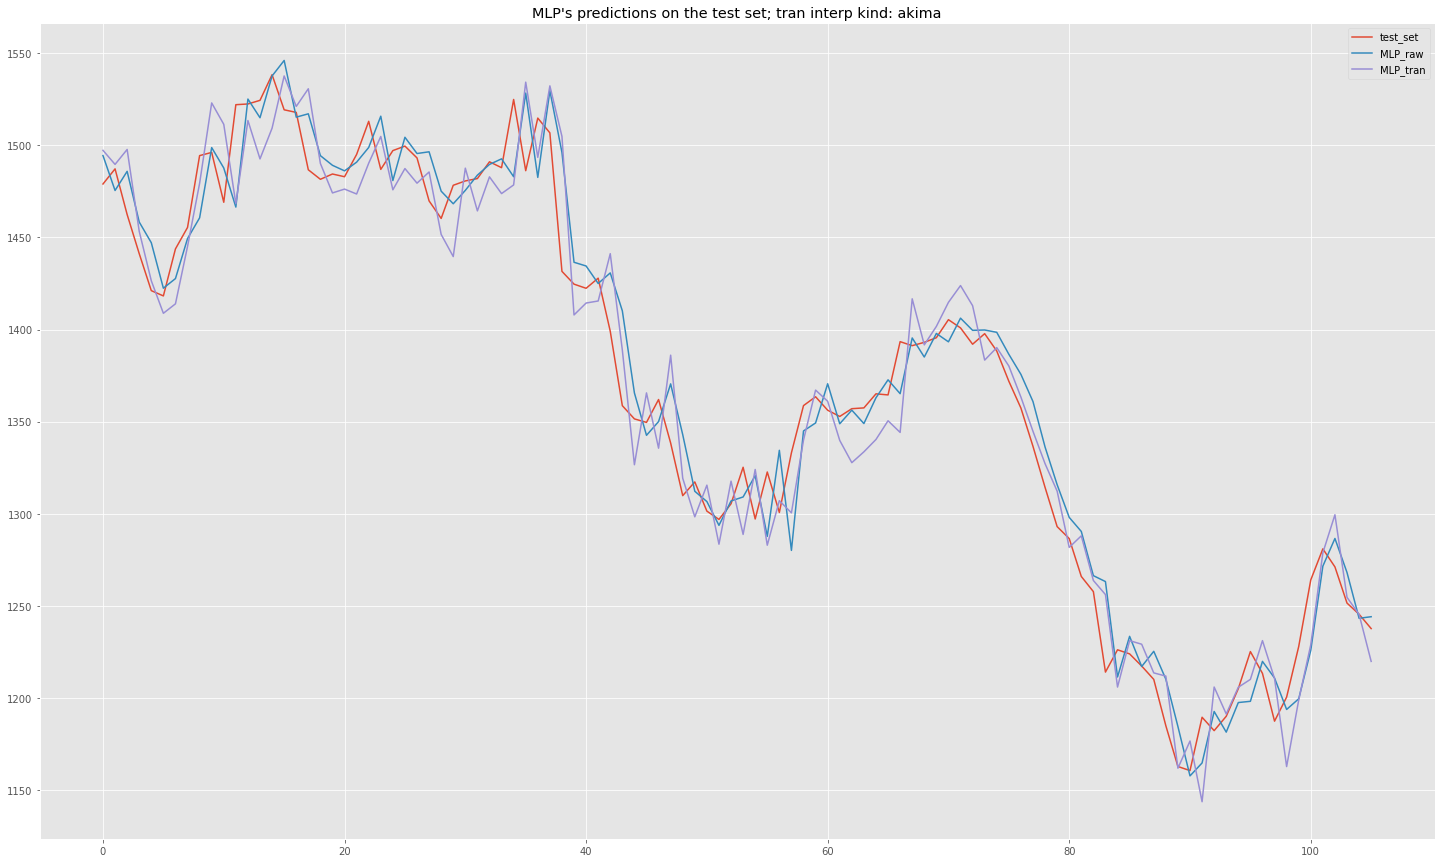

In [14]:
model = 'MLP'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

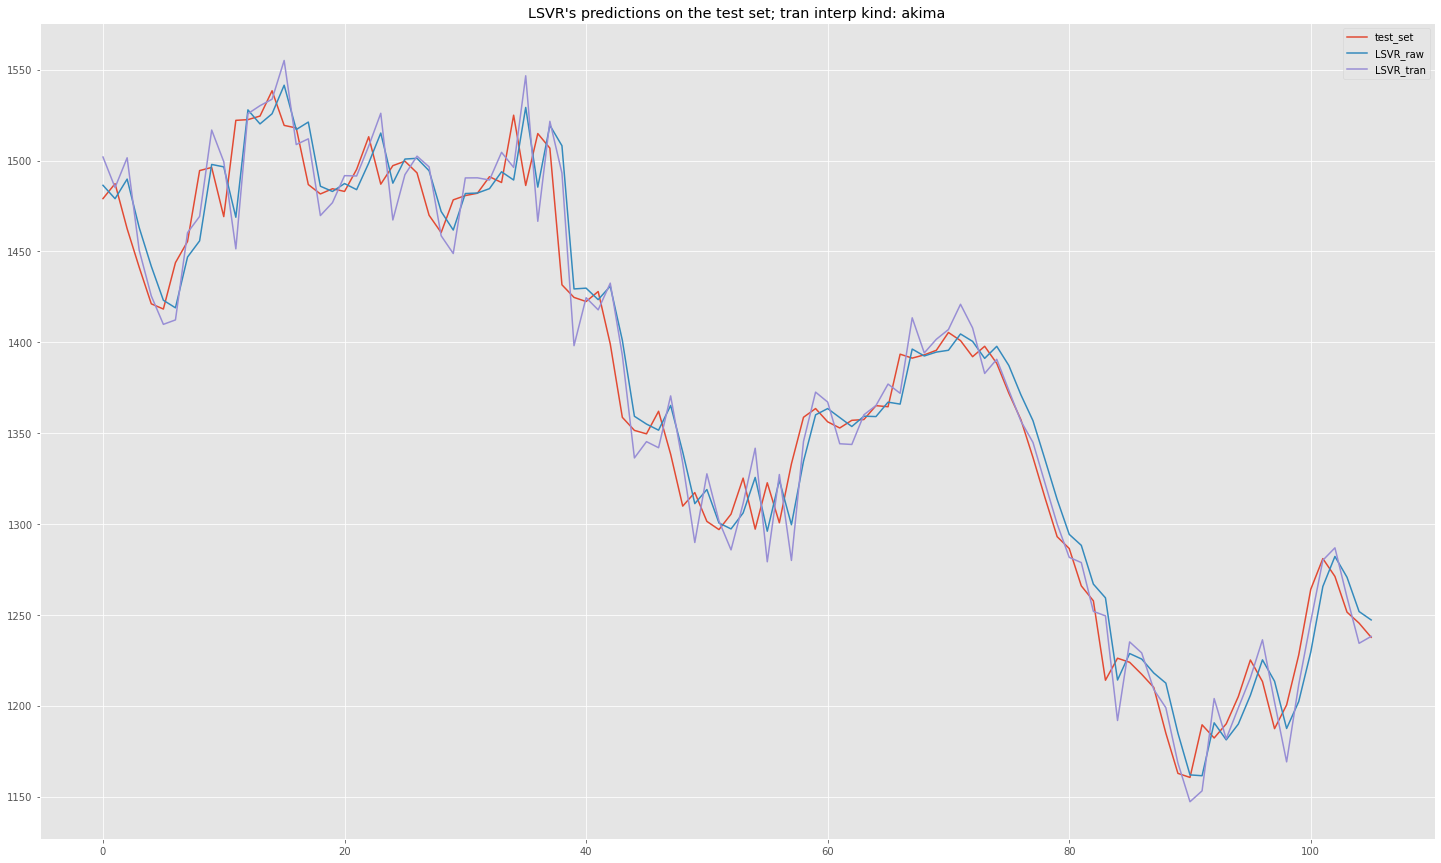

In [15]:
model = 'LSVR'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

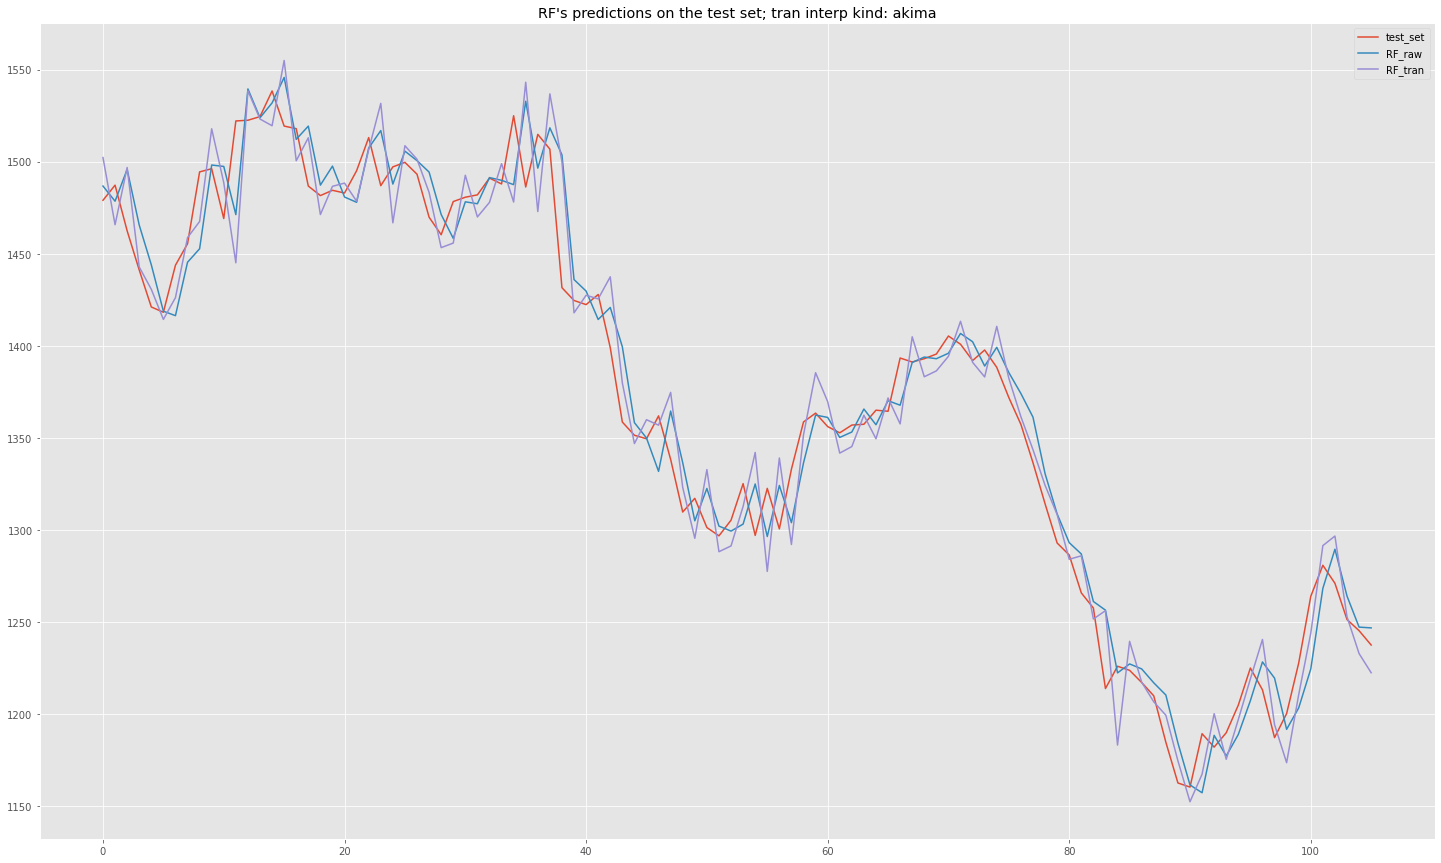

In [16]:
model = 'RF'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

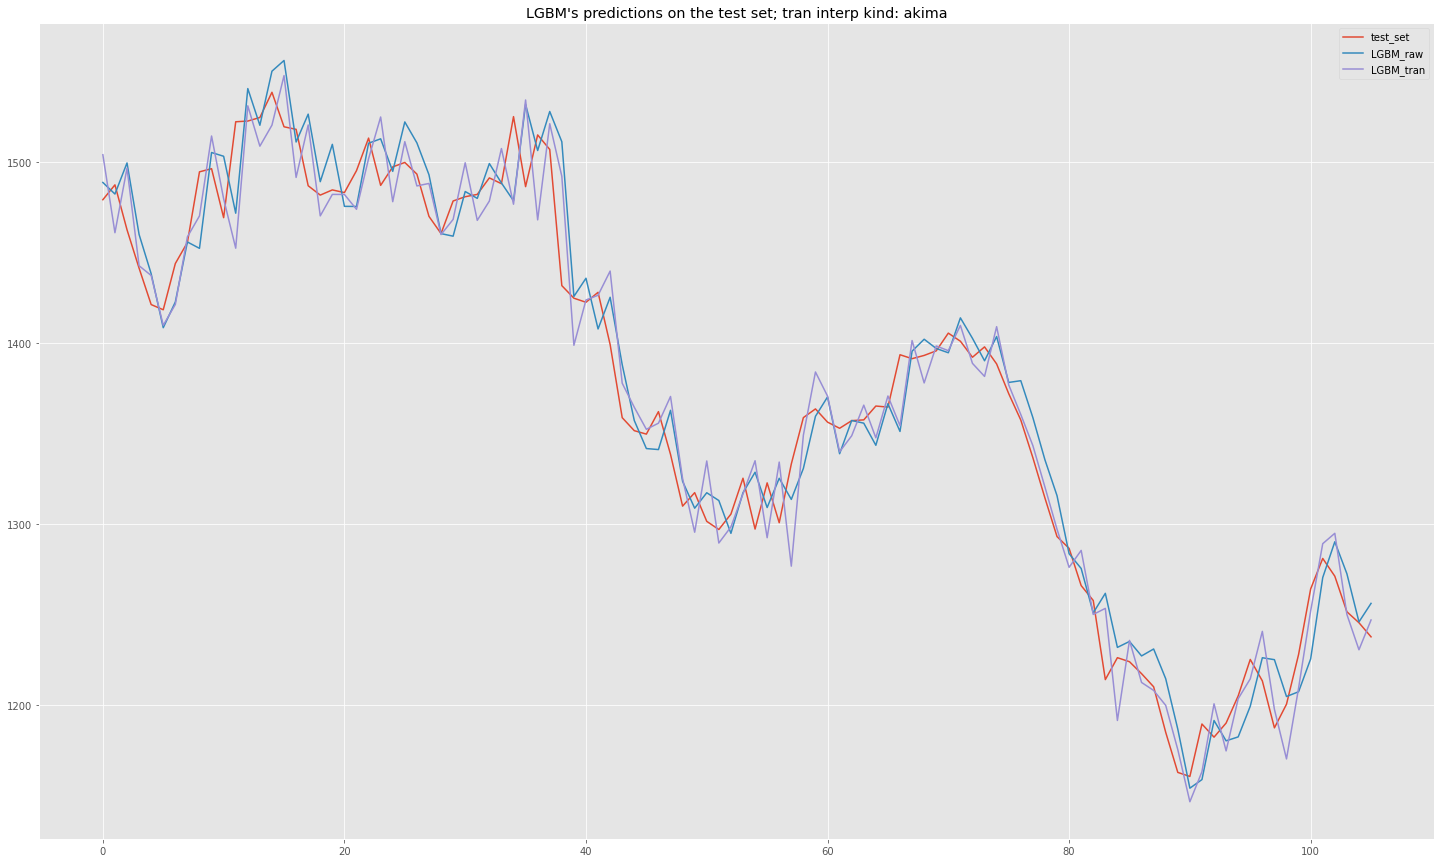

In [17]:
model = 'LGBM'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

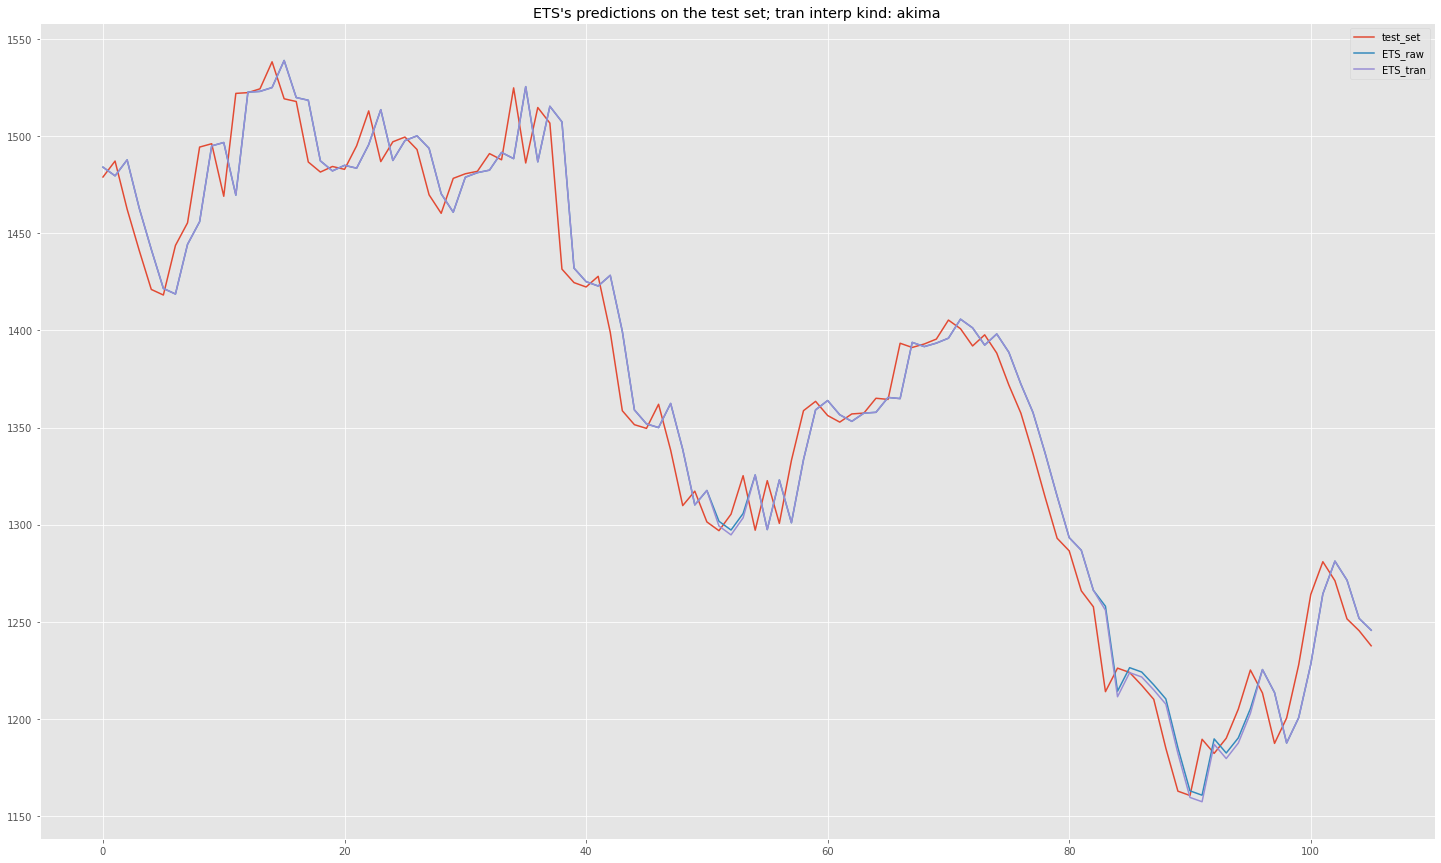

In [18]:
model = 'ETS'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

This time series experienced a serious exogeneous shock in its test set. We can see from this series how does the models handle shocks.

In [19]:
use = '2040'

In [20]:
# filter out the test set

test_size = run_infos[0]['config input']['modelling config']['test size']
test_set_count = int(len(ts[use]) * test_size)

test_set = ts[use][-(test_set_count):]

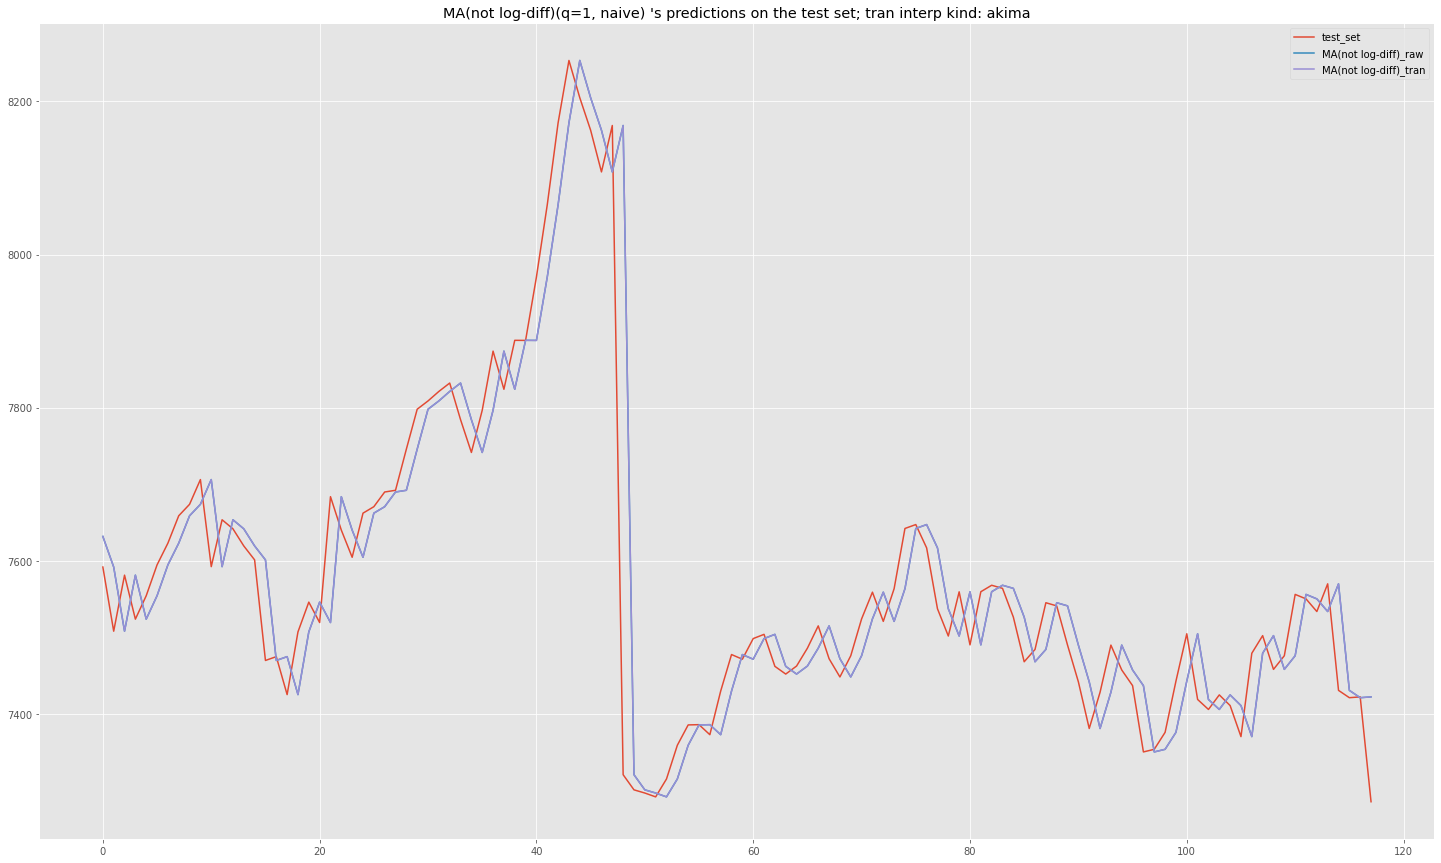

In [21]:
model = 'MA(not log-diff)'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}(q=1, naive) \'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

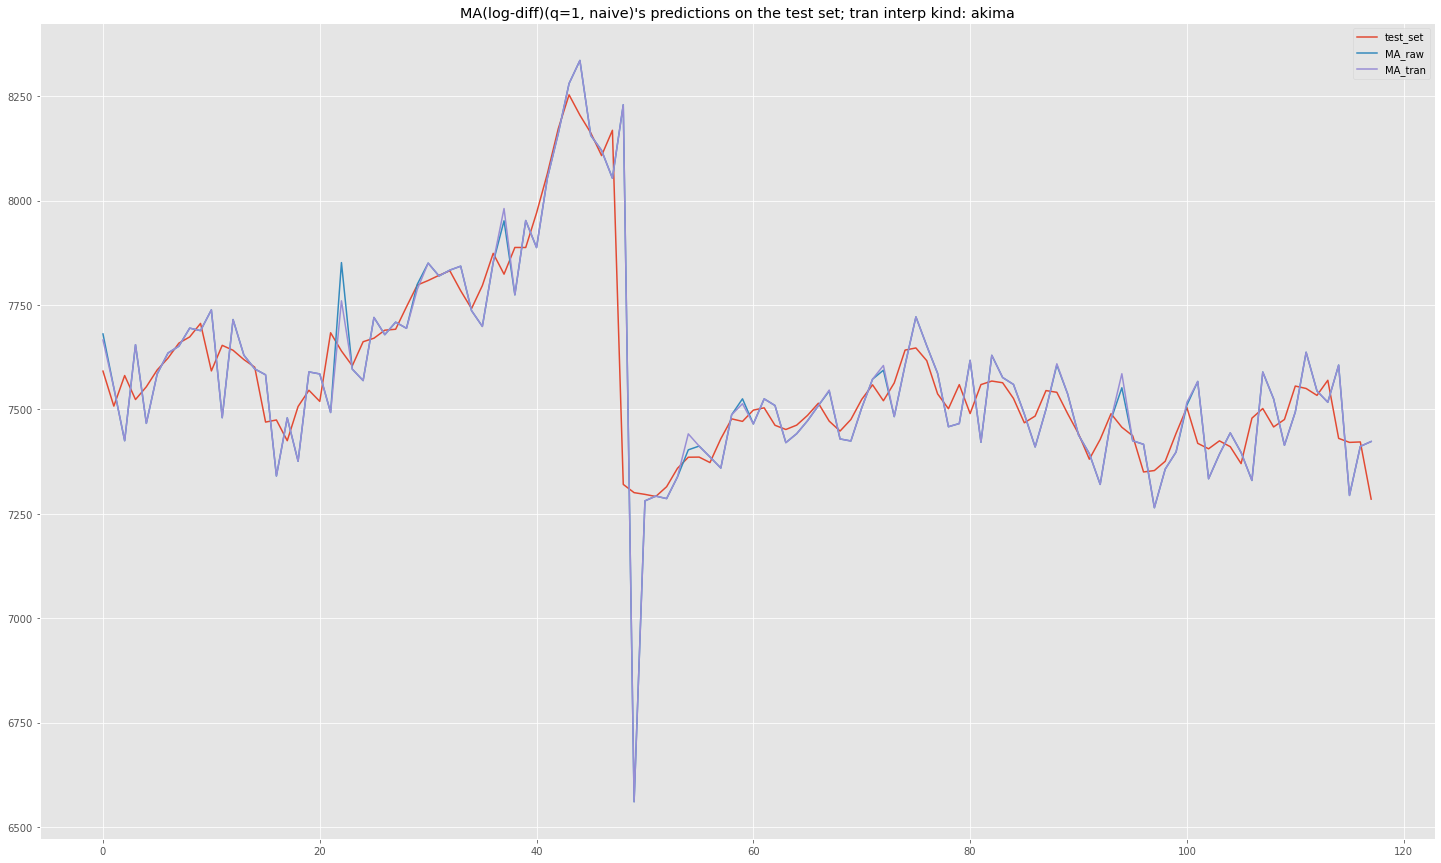

In [22]:
model = 'MA'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}(log-diff)(q=1, naive)\'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

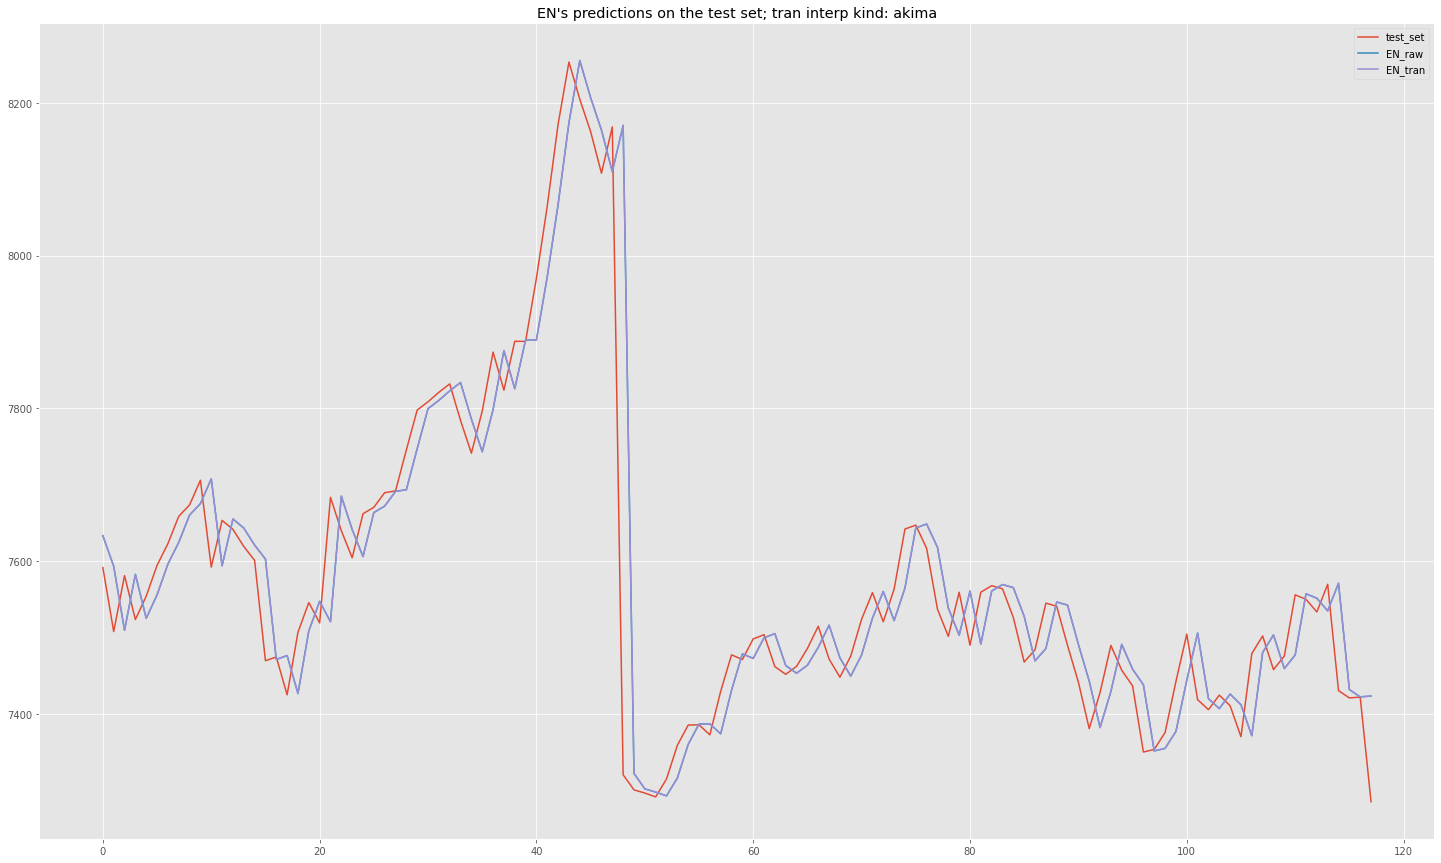

In [23]:
model = 'EN'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

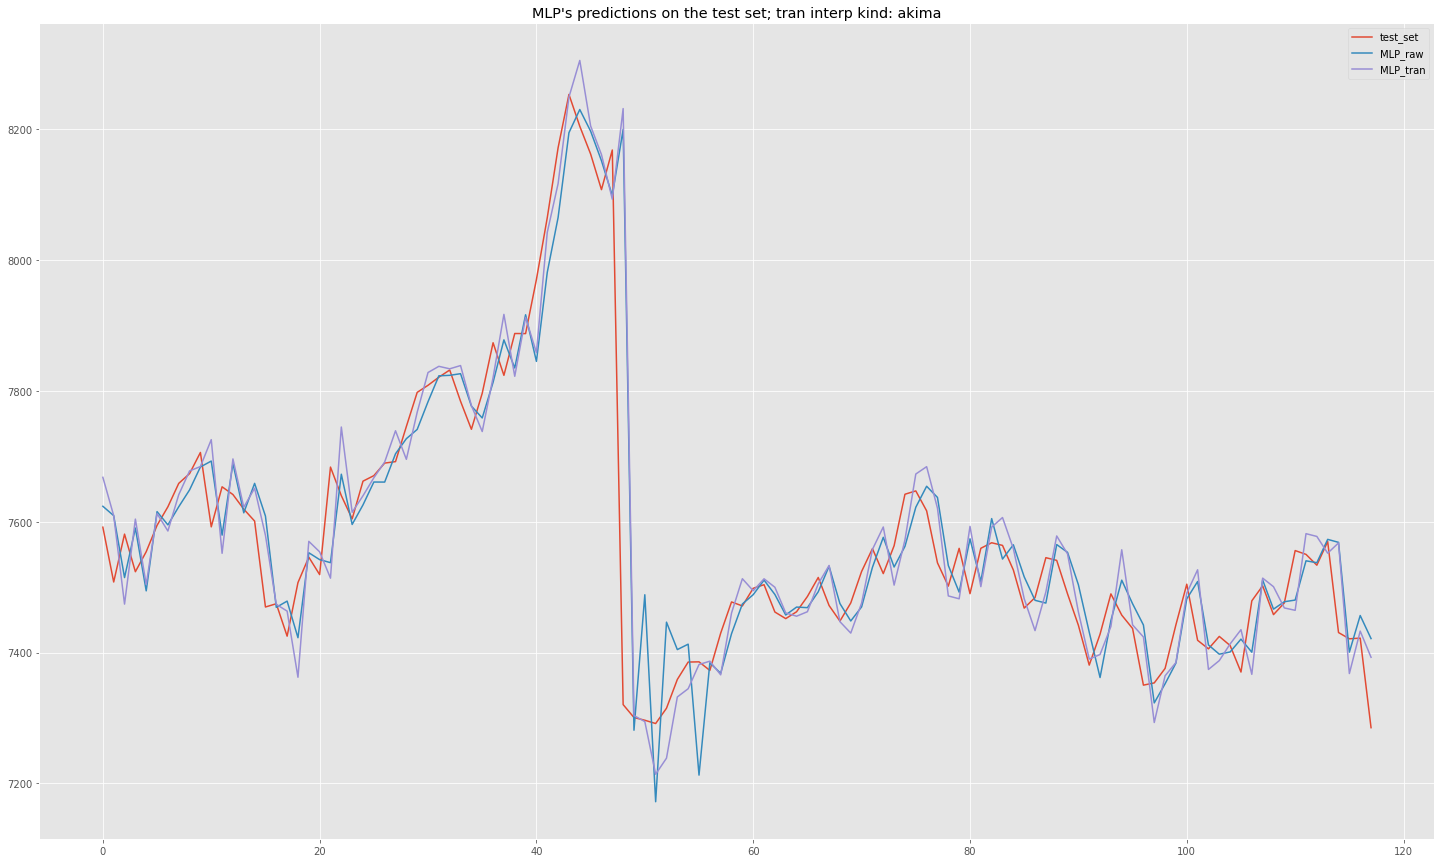

In [24]:
model = 'MLP'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

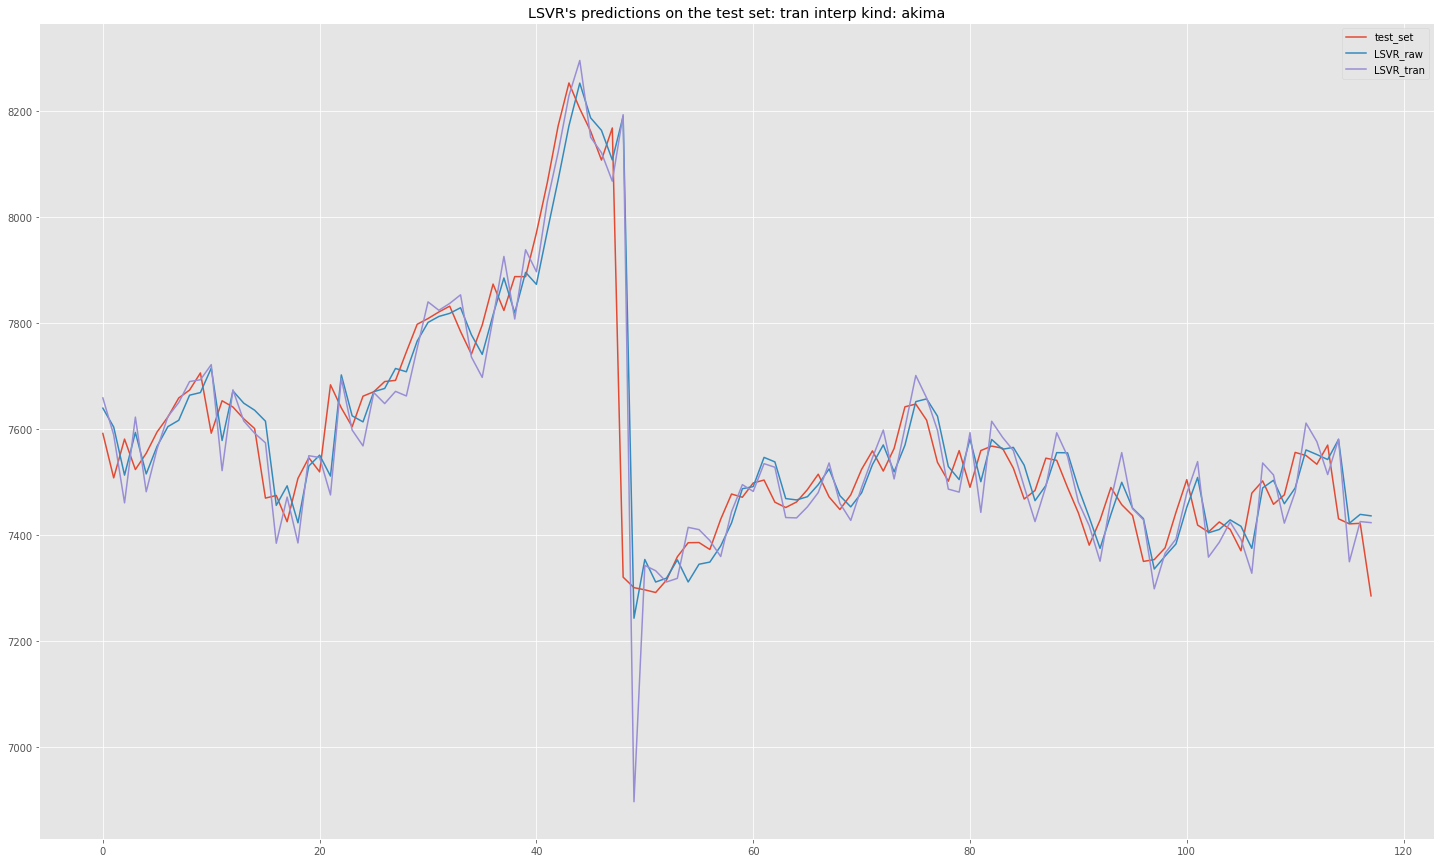

In [25]:
model = 'LSVR'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set: tran interp kind: {inter_kind}')
plt.legend()
plt.show()

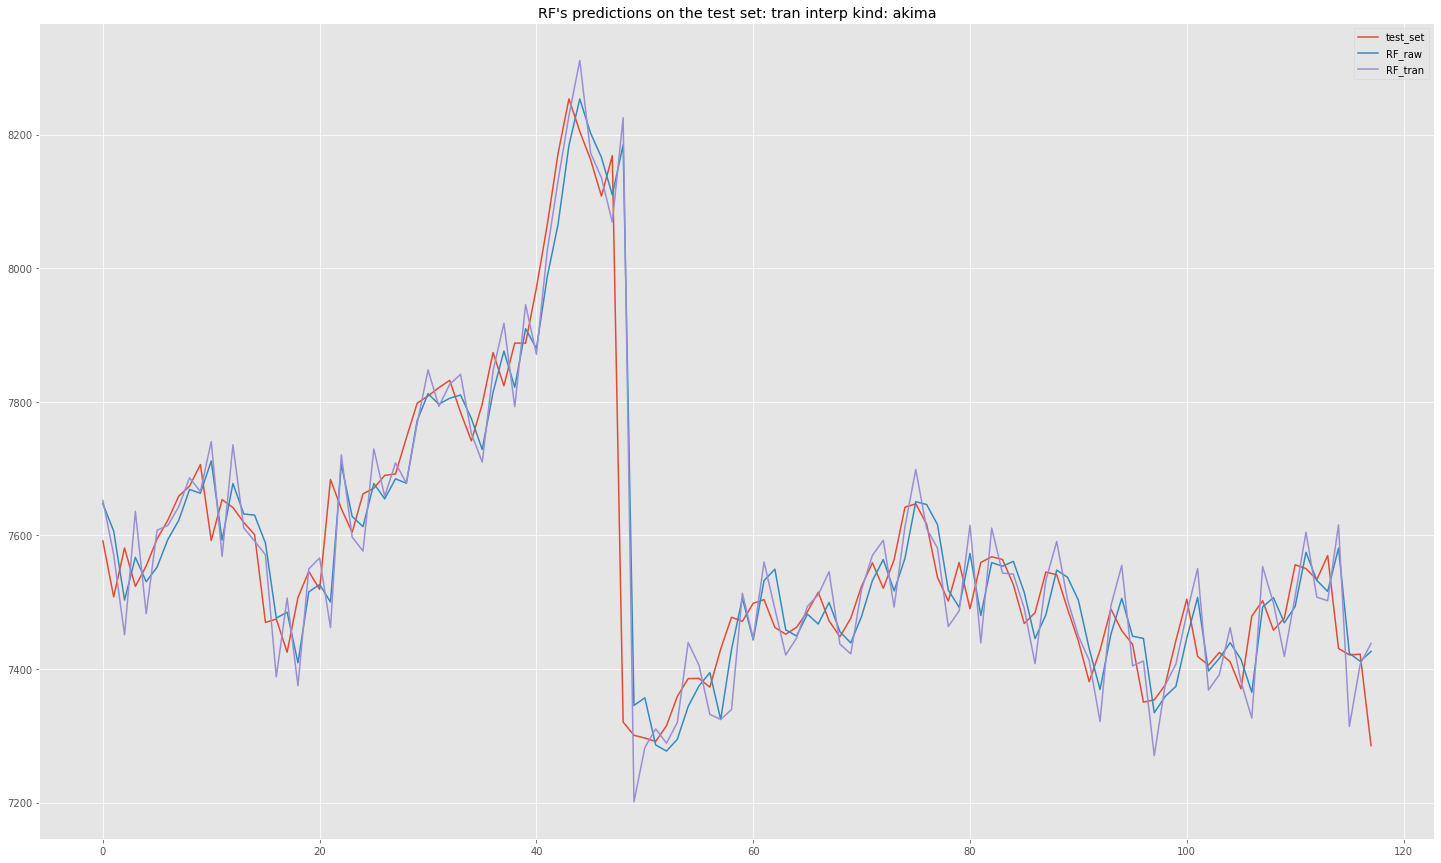

In [26]:
model = 'RF'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set: tran interp kind: {inter_kind}')
plt.legend()
plt.show()

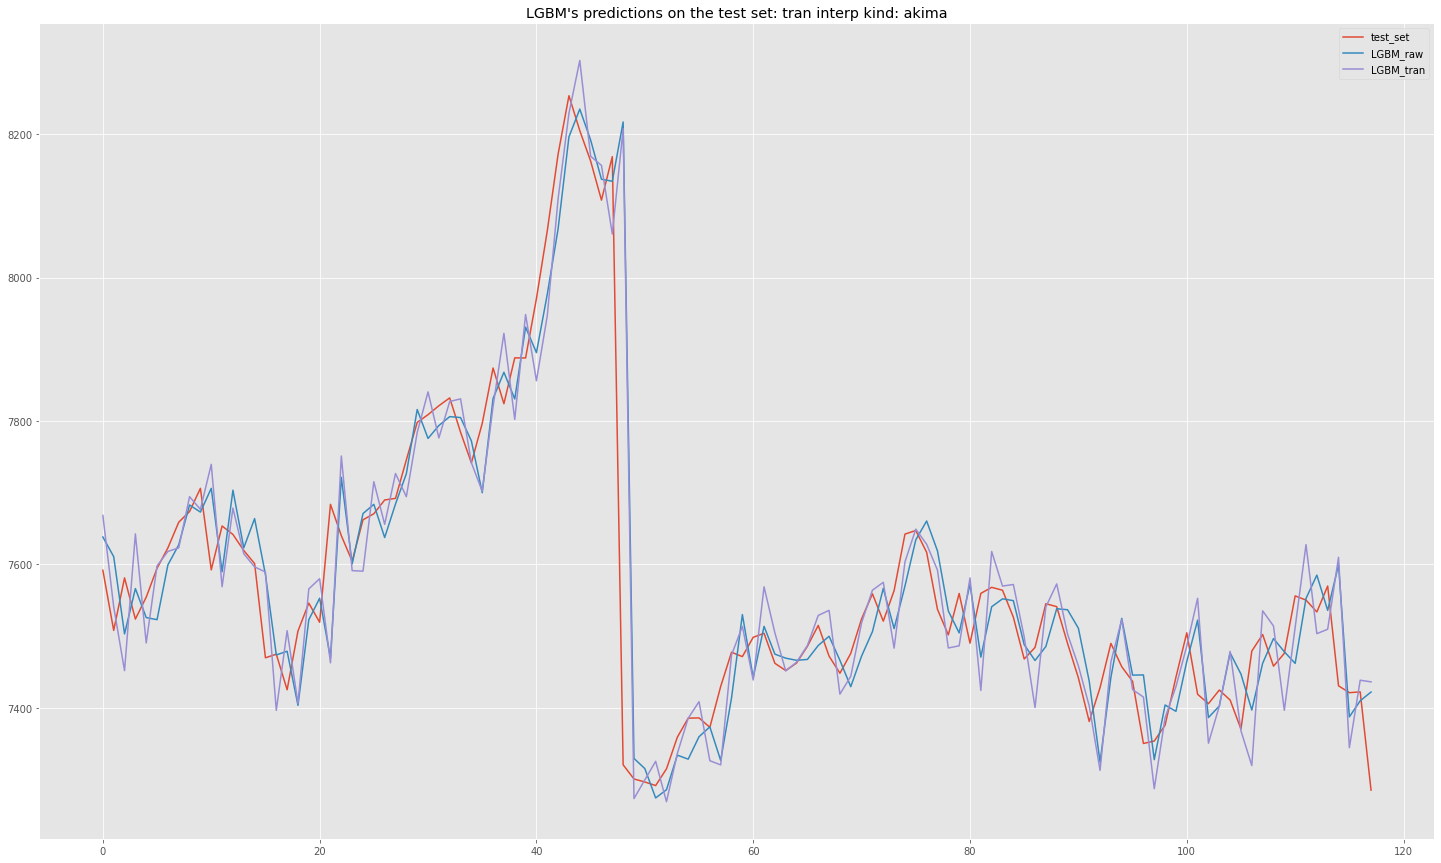

In [27]:
model = 'LGBM'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set: tran interp kind: {inter_kind}')
plt.legend()
plt.show()

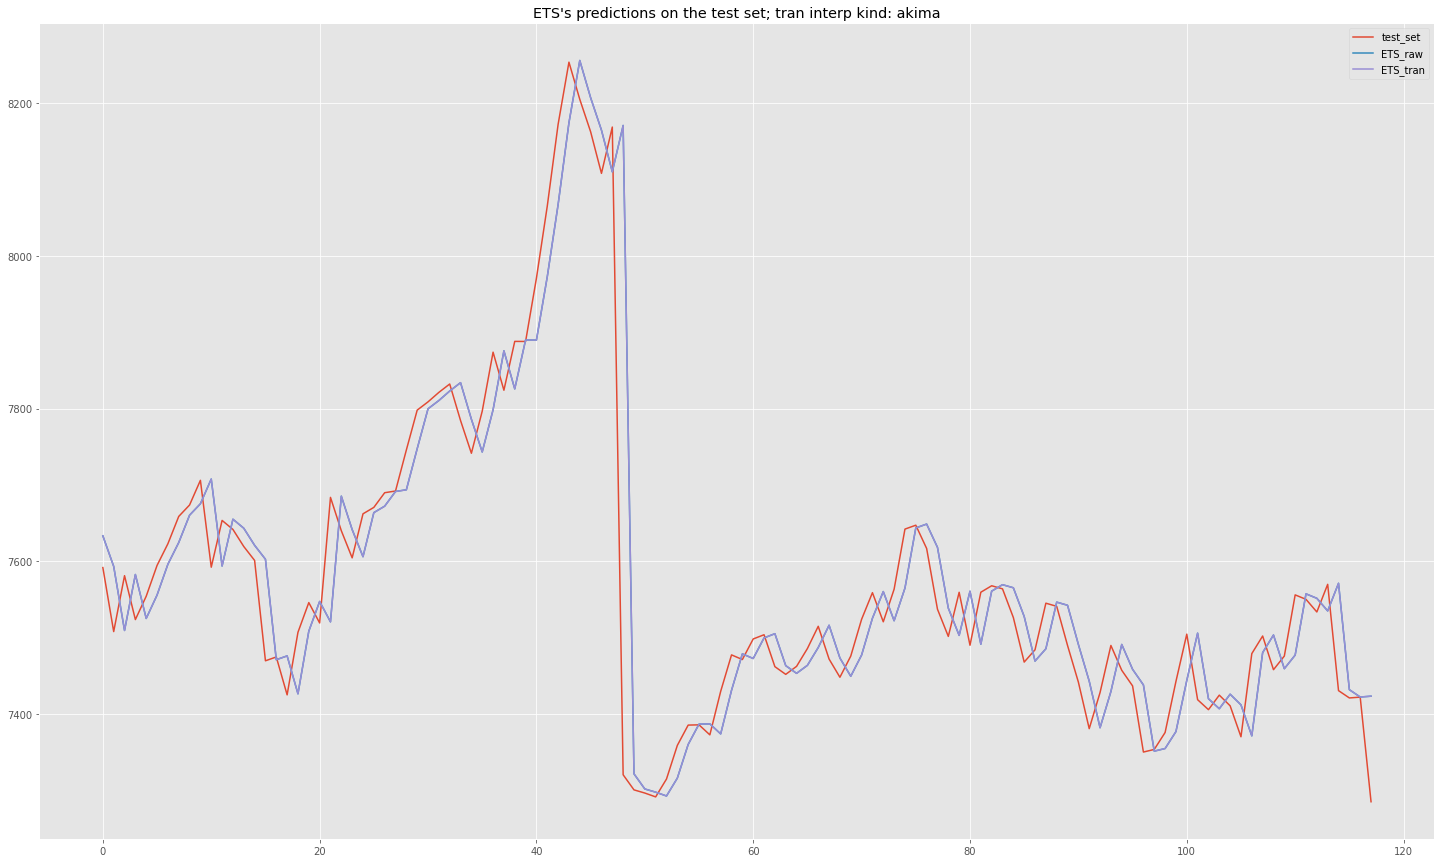

In [28]:
model = 'ETS'
inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

## Statistics of overall performance

In this section, we calculate some statistics that concludes the general performance of each agent over the time series played.

In addition to SMAPE, we compute the ranking of each agent per time series. So each agent will have a ranking for a time series, ranging from 1 to the number of agent involved. I store this ranking info to the `agent_infos` dictionary, as how SMAPE is stored for each agent per time series.

In [29]:
for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        score = play_info['test SMAPE']
        lower = [1 for a in agent_infos.keys() if agent_infos[a][series]['test SMAPE']-score < 0]
        play_info['ranking'] = sum(lower) + 1

In [30]:
numbers = {
    agent: {
        'SMAPEs': [],
        'rankings': []
    } for agent in agent_infos
}

stats = {
    agent: {
        'mean SMAPE': None,
        'std. SMAPE': None,
        'mean ranking': None,
        'std. ranking': None
    } for agent in agent_infos
}

for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        numbers[agent]['SMAPEs'].append(play_info['test SMAPE'])
        numbers[agent]['rankings'].append(play_info['ranking'])
    
    stats[agent]['mean SMAPE'] = np.mean(numbers[agent]['SMAPEs'])
    stats[agent]['std. SMAPE'] = np.std(numbers[agent]['SMAPEs'])
    stats[agent]['mean ranking'] = np.mean(numbers[agent]['rankings'])
    stats[agent]['std. ranking'] = np.std(numbers[agent]['rankings'])

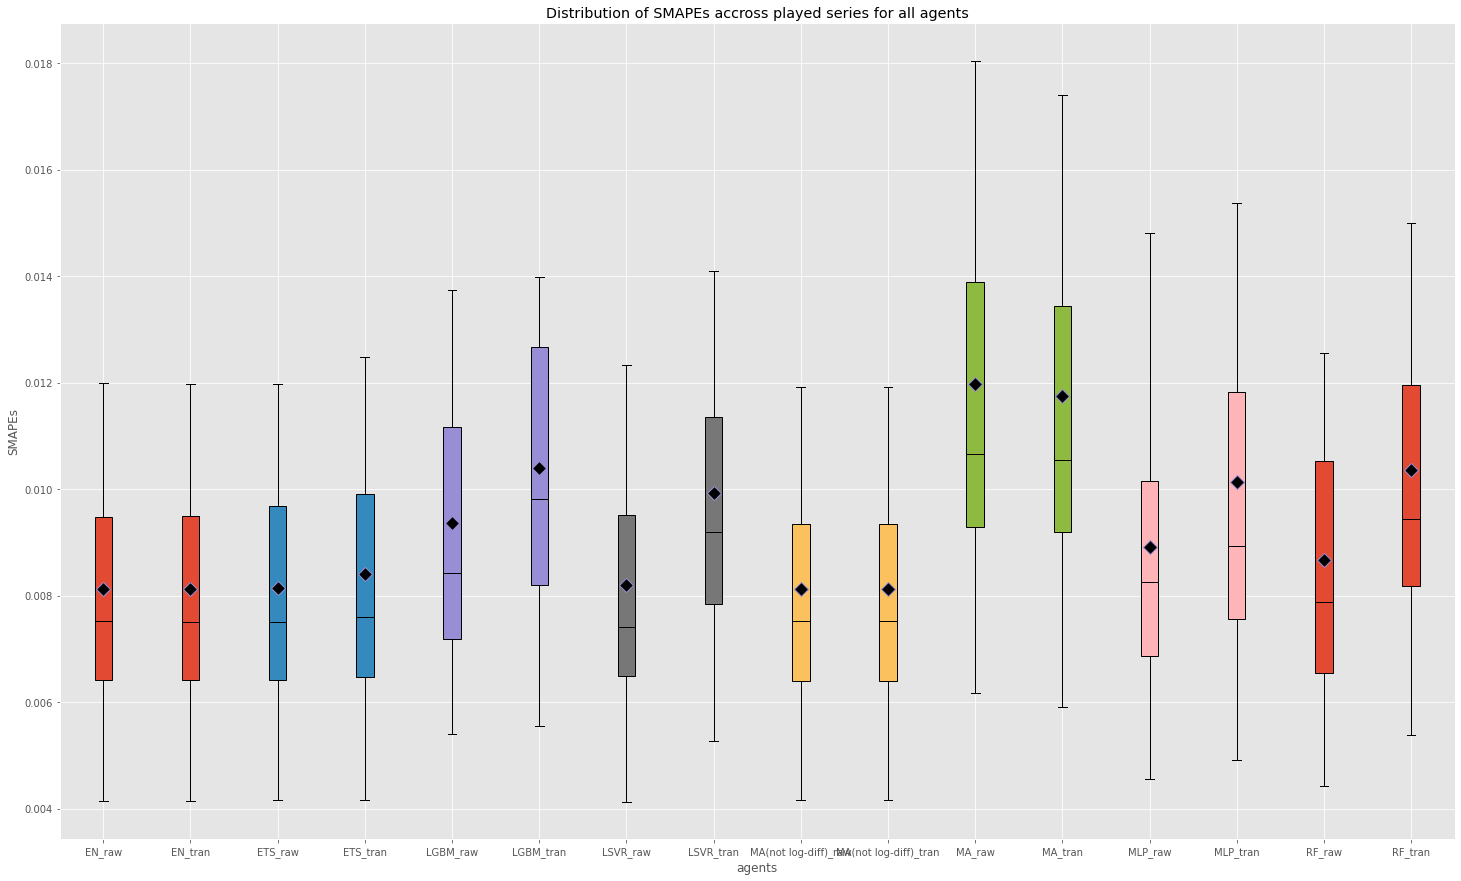

In [31]:
plt.figure(figsize= (25, 15))
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//2)]
meanprop = dict(marker='D', markerfacecolor='black', markersize=10)

box = plt.boxplot(
    [agent['SMAPEs'] for agent in numbers.values()],
    showbox=True,
    showfliers=False,
    labels=list(numbers.keys()),
    widths=0.2,
    showmeans=True,
    meanprops=meanprop,
    patch_artist=True)

for i, patch in enumerate(box['boxes']):
    c = i // (n_agents//(n_agents//2))
    patch.set_facecolor(colors[c])
    box['medians'][i].set_color('k')

plt.title(f'Distribution of SMAPEs accross played series for all agents')
plt.xlabel('agents')
plt.ylabel('SMAPEs')
plt.show()

## Ranking of the agents

In this section, we compute the alpha-confidence interval of the rankings for the agents.

In [32]:
series_ran = agent_infos['MLP_raw'].keys()
n_series_ran = len(series_ran)

alpha = 0.1
Q = len(list(agent_infos.keys()))
P = n_series_ran
dist = np.random.standard_normal(size=Q)
r_lower, r_upper = np.min(dist), np.max(dist)
qrange = list(np.arange(r_lower, r_upper, step=(r_upper-r_lower)/100))
q_alpha_Q = qrange[-int(alpha*100)]

def conf_limit(Q, P, mean_R, q_alpha_Q):
    stat = 0.5 * q_alpha_Q * np.sqrt(Q*(Q+1)/(12 * P))
    return round(mean_R-stat, 6), round(mean_R+stat, 6)

for agent in agent_infos.keys():
    stats[agent][f'{100-int(alpha*100)}% ranking confi. limits'] = conf_limit(Q, P, stats[agent]['mean ranking'], q_alpha_Q)

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_raw,EN_tran,ETS_raw,ETS_tran,LGBM_raw,LGBM_tran,LSVR_raw,LSVR_tran,MA(not log-diff)_raw,MA(not log-diff)_tran,MA_raw,MA_tran,MLP_raw,MLP_tran,RF_raw,RF_tran
mean SMAPE,0.008129,0.008129,0.008149,0.008404,0.009363,0.010389,0.008198,0.009928,0.008126,0.008126,0.011975,0.01174,0.008918,0.010128,0.008668,0.010352
std. SMAPE,0.002735,0.002736,0.002748,0.002817,0.003227,0.003797,0.00281,0.003408,0.002733,0.002733,0.004624,0.004411,0.003372,0.004259,0.003185,0.003774
mean ranking,3.5,3.56,4.0,5.86,10.34,12.76,5.04,11.8,2.72,2.72,15.72,15.0,8.94,11.68,7.88,12.8
std. ranking,1.486607,1.4988,1.56205,2.828498,1.62,1.504128,2.62267,1.077033,1.789302,1.789302,0.491528,0.632456,1.475263,1.76,1.966113,1.216553
90% ranking confi. limits,"(3.304326, 3.695674)","(3.364326, 3.755674)","(3.804326, 4.195674)","(5.664326, 6.055674)","(10.144326, 10.535674)","(12.564326, 12.955674)","(4.844326, 5.235674)","(11.604326, 11.995674)","(2.524326, 2.915674)","(2.524326, 2.915674)","(15.524326, 15.915674)","(14.804326, 15.195674)","(8.744326, 9.135674)","(11.484326, 11.875674)","(7.684326, 8.075674)","(12.604326, 12.995674)"


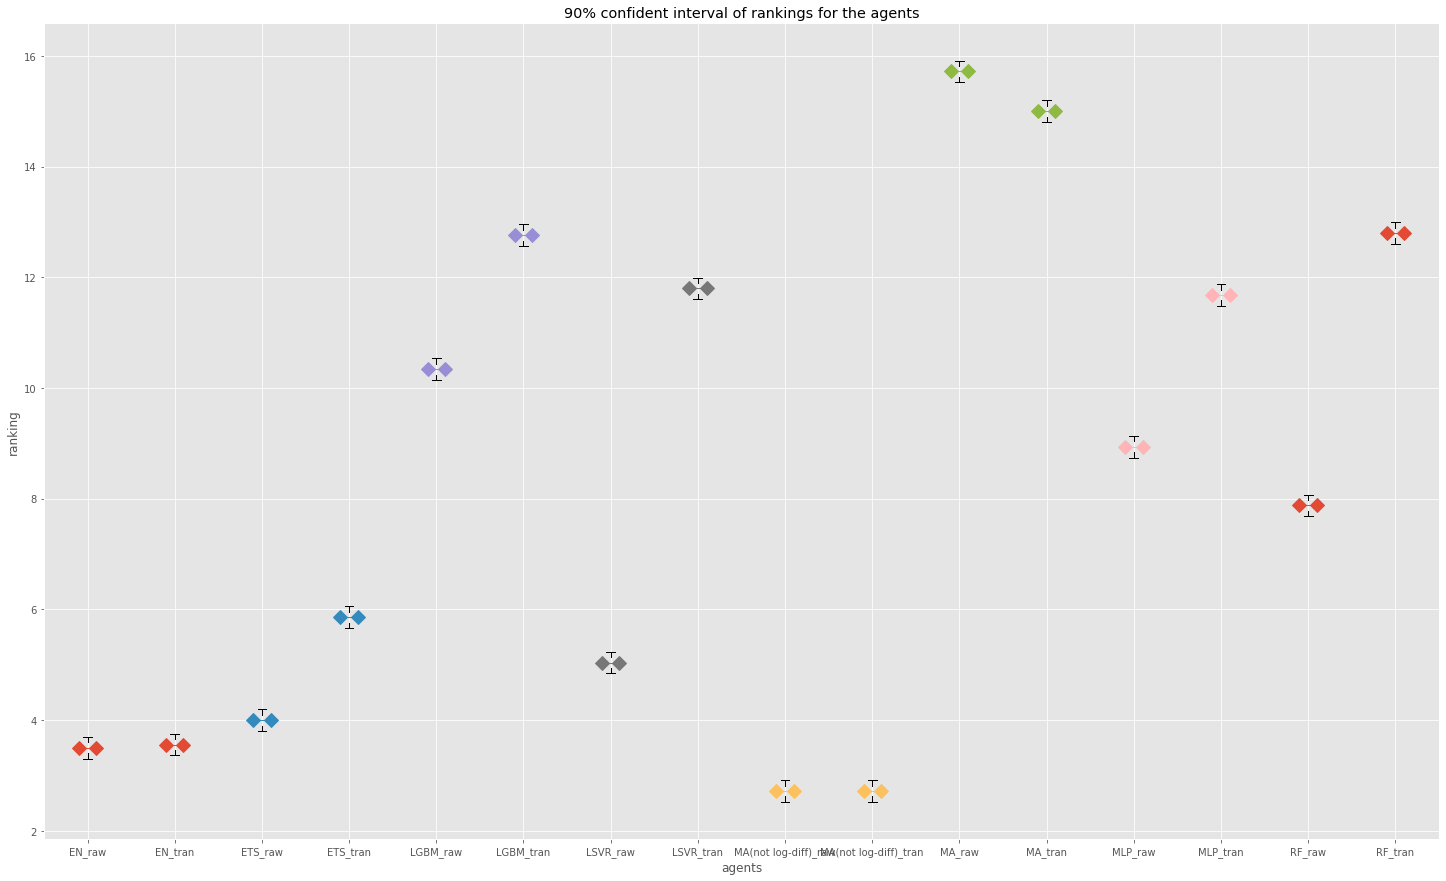

In [33]:
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//2)]
medianprop = dict(marker='D', markersize=10)
plt.figure(figsize= (25, 15))
box = plt.boxplot(
    [
        [
            agent[f'{100-int(alpha*100)}% ranking confi. limits'][0],
            agent['mean ranking'],
            agent[f'{100-int(alpha*100)}% ranking confi. limits'][1]
        ] for agent in stats.values()
    ],
    showbox=False,
    labels=list(numbers.keys()),
    widths=0.2,
    medianprops=medianprop,
    patch_artist=True)

for i, patch in enumerate(box['medians']):
    c = i // (n_agents//(n_agents//2))
    patch.set_color(colors[c])

plt.title(f'{100-int(alpha*100)}% confident interval of rankings for the agents')
plt.xlabel('agents')
plt.ylabel('ranking')
plt.show()

## Fraction best

In this section, we compute another performance measure, called the fraction-best measure. Building on our basis performance measure SMAPE, we compute how much of a fraction out of all played time series that a model beats all other models. This measure lets us know the potential of an agent being exceptionally good conditional on the given datasets.

The results are shown in the last row of the table.

In [34]:
for agent, play_info in stats.items():
    play_info['frac best'] = np.sum([1 for r in numbers[agent]['rankings'] if r == 1])/n_series_ran

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_raw,EN_tran,ETS_raw,ETS_tran,LGBM_raw,LGBM_tran,LSVR_raw,LSVR_tran,MA(not log-diff)_raw,MA(not log-diff)_tran,MA_raw,MA_tran,MLP_raw,MLP_tran,RF_raw,RF_tran
mean SMAPE,0.008129,0.008129,0.008149,0.008404,0.009363,0.010389,0.008198,0.009928,0.008126,0.008126,0.011975,0.01174,0.008918,0.010128,0.008668,0.010352
std. SMAPE,0.002735,0.002736,0.002748,0.002817,0.003227,0.003797,0.00281,0.003408,0.002733,0.002733,0.004624,0.004411,0.003372,0.004259,0.003185,0.003774
mean ranking,3.5,3.56,4.0,5.86,10.34,12.76,5.04,11.8,2.72,2.72,15.72,15.0,8.94,11.68,7.88,12.8
std. ranking,1.486607,1.4988,1.56205,2.828498,1.62,1.504128,2.62267,1.077033,1.789302,1.789302,0.491528,0.632456,1.475263,1.76,1.966113,1.216553
90% ranking confi. limits,"(3.304326, 3.695674)","(3.364326, 3.755674)","(3.804326, 4.195674)","(5.664326, 6.055674)","(10.144326, 10.535674)","(12.564326, 12.955674)","(4.844326, 5.235674)","(11.604326, 11.995674)","(2.524326, 2.915674)","(2.524326, 2.915674)","(15.524326, 15.915674)","(14.804326, 15.195674)","(8.744326, 9.135674)","(11.484326, 11.875674)","(7.684326, 8.075674)","(12.604326, 12.995674)"
frac best,0.1,0.1,0.1,0.1,0.0,0.0,0.28,0.0,0.38,0.38,0.0,0.0,0.0,0.0,0.02,0.0


# Feature importance analysis

In this section, we investigate the parameters estimated by the machine learning models to gain more insights on how the models learn the problems. In particular, we go through

- feature importance reported by the tree-based models (RF, LGBM)
- coefficients estimated by the linear regression model (EN)

In [35]:
# find out the indices of the series played that I have the feature importances recorded
runs =['13-07-2022--18-20-12']
played = []

for run in runs:
    with open(f'{run}/EN_tran.json', 'r') as file:
        temp = json.load(file)
    played += list(temp.keys())

played

['2040',
 '2041',
 '2044',
 '2045',
 '2078',
 '2080',
 '2081',
 '2137',
 '2214',
 '2292',
 '2310',
 '2315',
 '2317',
 '2370',
 '2425',
 '2432',
 '2439',
 '2440',
 '2483',
 '2484',
 '2485',
 '2497',
 '2502',
 '2503',
 '2516',
 '2517',
 '2518',
 '2526',
 '2551',
 '2552',
 '2553',
 '2575',
 '2576',
 '2577',
 '2578',
 '2580',
 '2588',
 '2589',
 '2590',
 '2591',
 '2592',
 '2595',
 '2621',
 '2622',
 '2623',
 '2624',
 '2625',
 '2753',
 '2754',
 '2755']

In [36]:
# find out the maximum number of lags possible
max_n_lag = 21
states = True
if states:
    n_states = 8
else:
    n_states = 0

## Tree-based models

In this section, we investigate the feature importance reported by the tree-based methods.

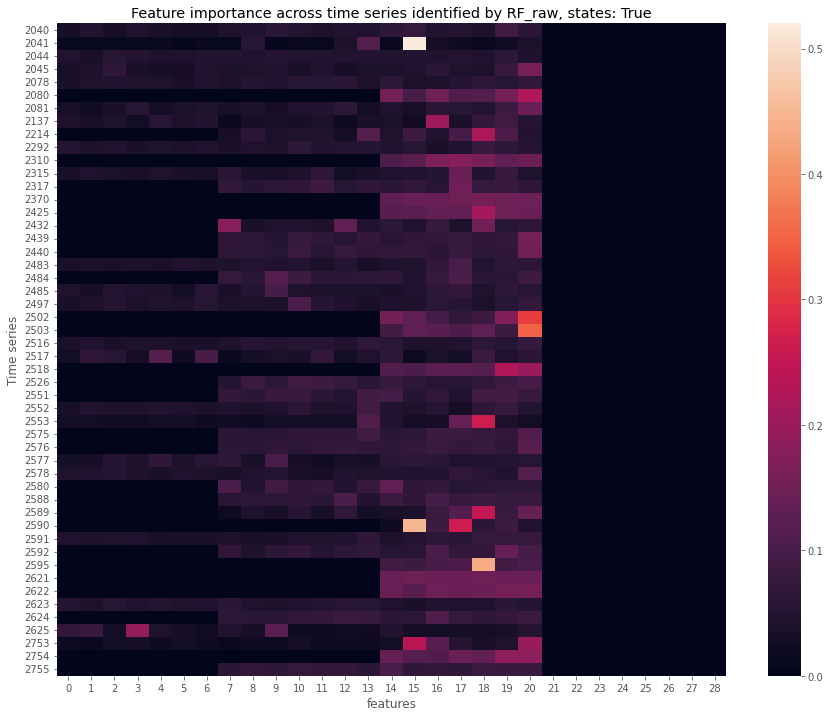

In [37]:
import matplotlib.pylab as pltlab
import seaborn as sns

model = 'RF_raw'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue

    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag:
        heatmap_grid.append(fi + [0 for _ in range(n_states)])
    else:
        n_gap = max_n_lag - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi + [0 for _ in range(n_states)])

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

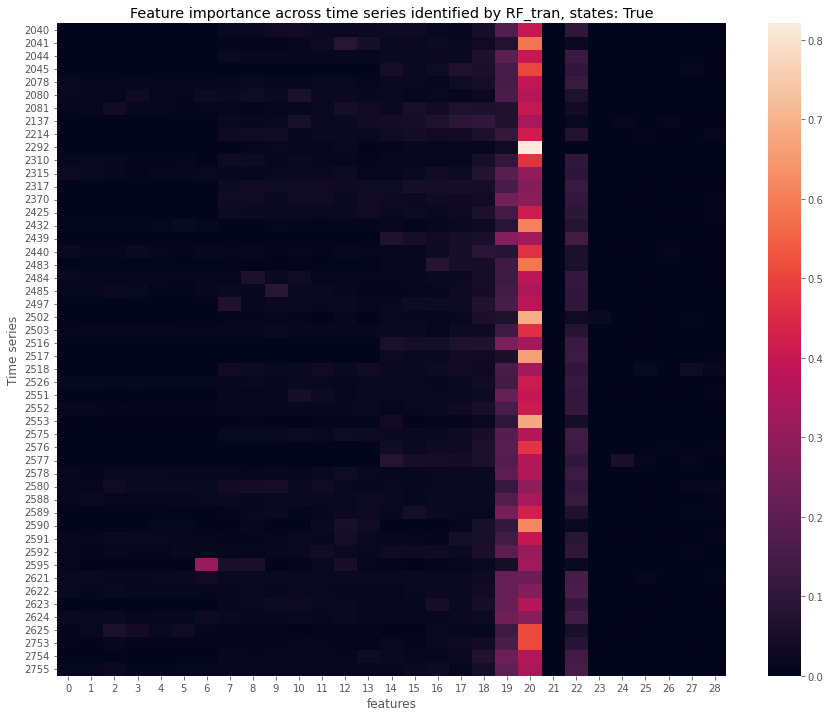

In [38]:
model = 'RF_tran'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag + n_states:
        heatmap_grid.append(fi)
    else:
        n_gap = max_n_lag + n_states - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

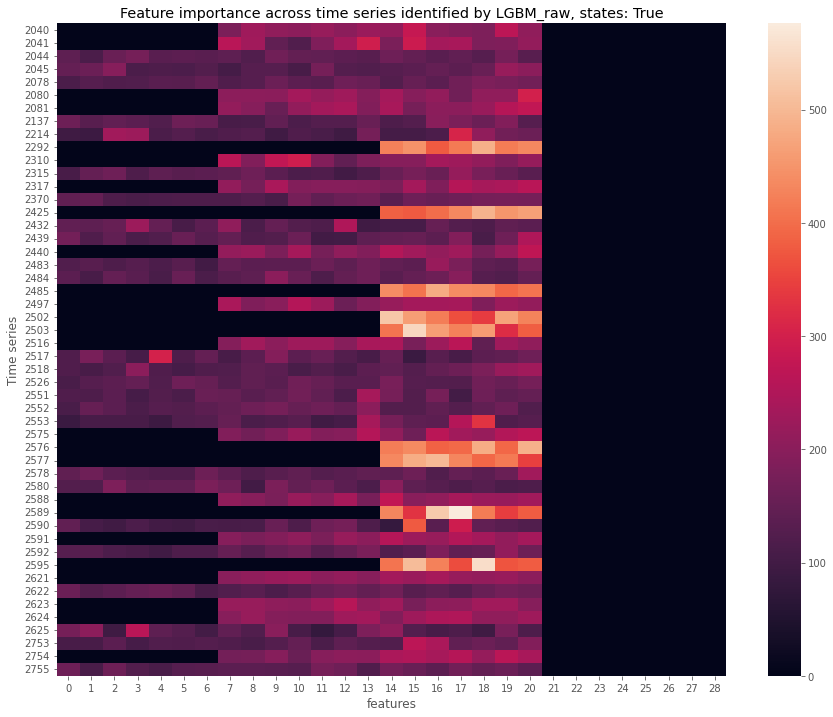

In [39]:
model = 'LGBM_raw'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag:
        heatmap_grid.append(fi + [0 for _ in range(n_states)])
    else:
        n_gap = max_n_lag - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi + [0 for _ in range(n_states)])

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

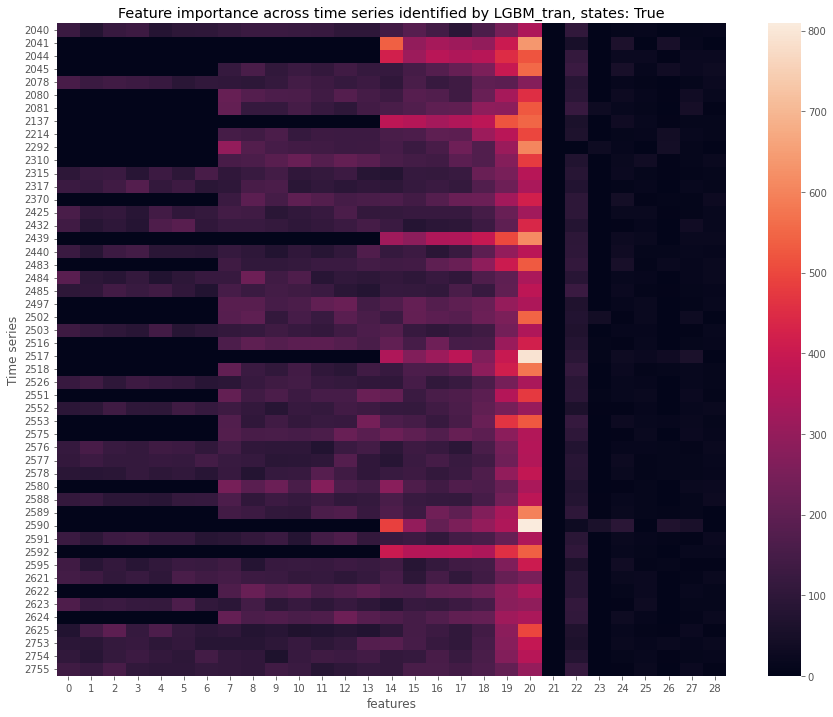

In [40]:
model = 'LGBM_tran'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag + n_states:
        heatmap_grid.append(fi)
    else:
        n_gap = max_n_lag + n_states - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

# Linear regression model

In this section, we investigate the coefficients estimated by the linear regression model, in this case, EN. Note that since we fitted the linear model with intercept, we have an additional feature to the number of lags.

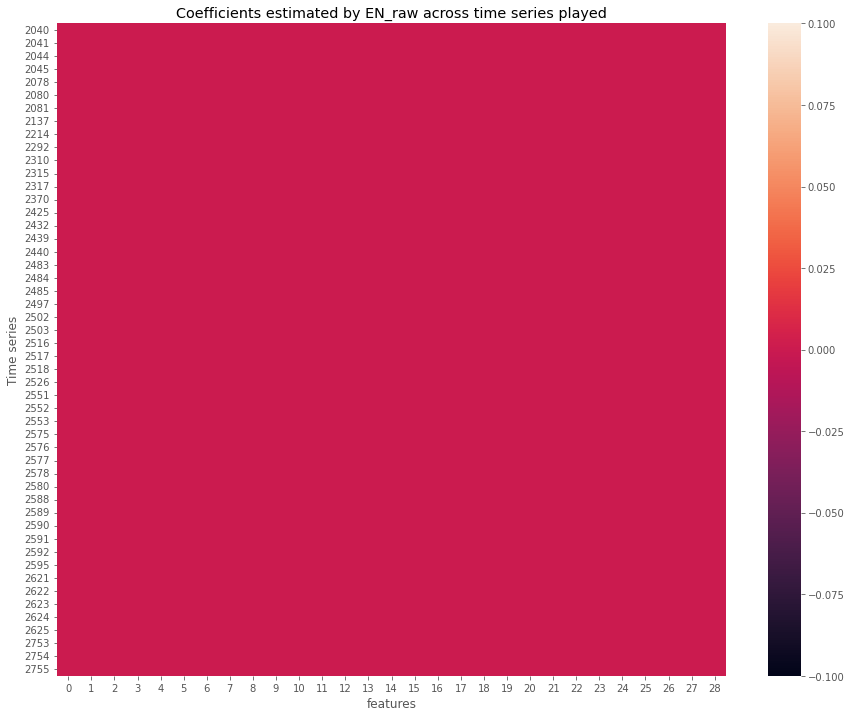

In [41]:
model = 'EN_raw'

# @NOTE: do not turn this to true, scale incomparable!!!
include_intercept = False

n_intercept = 1

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    if include_intercept:
        coeffs = play['coeffs'][-1]
        n_intercept_c = n_intercept
    else:
        coeffs = play['coeffs'][-1][n_intercept:]
        n_intercept_c = 0
    if len(coeffs) == max_n_lag + n_intercept_c:
        heatmap_grid.append(coeffs + [0 for _ in range(n_states)])
    else:
        n_gap = max_n_lag  + n_intercept_c - len(coeffs)
        heatmap_grid.append([0 for _ in range(n_gap)] + coeffs + [0 for _ in range(n_states)])

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Coefficients estimated by {model} across time series played')
plt.show()

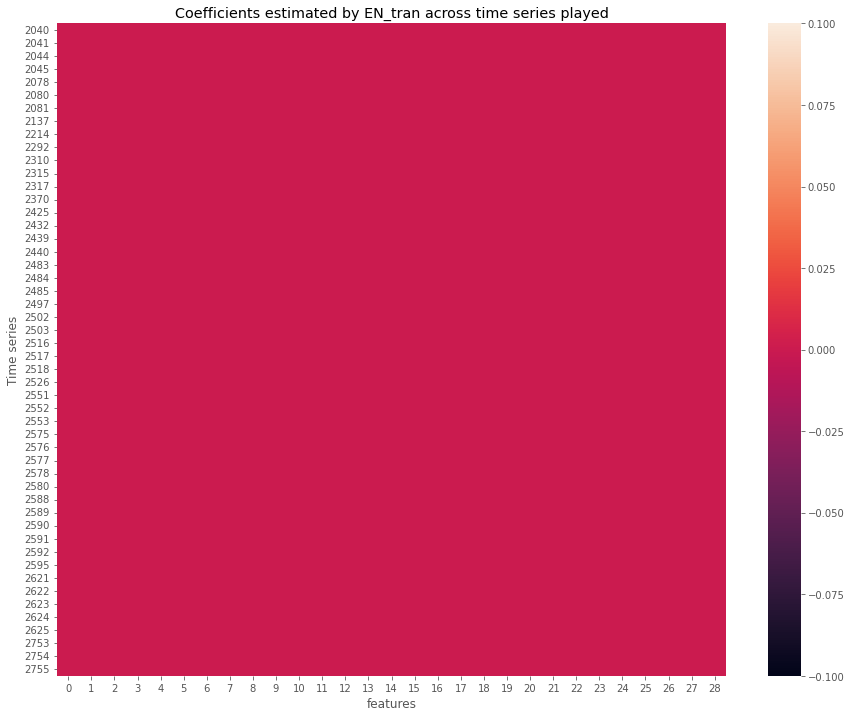

In [42]:
model = 'EN_tran'

# @NOTE: do not turn this to true, scale incomparable!!!
include_intercept = False

n_intercept = 1

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    if include_intercept:
        coeffs = play['coeffs'][-1]
        n_intercept_c = n_intercept
    else:
        coeffs = play['coeffs'][-1][n_intercept:]
        n_intercept_c = 0
    if len(coeffs) == max_n_lag + n_intercept_c + n_states:
        heatmap_grid.append(coeffs)
    else:
        n_gap = max_n_lag + n_states + n_intercept_c - len(coeffs)
        heatmap_grid.append([0 for _ in range(n_gap)] + coeffs)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Coefficients estimated by {model} across time series played')
plt.show()

# Replicate the train to get more information

In the case of some of the information is not explicitly recorded from the experiment, there is a good chance it's implicitly contained in the recorded information. In this section, we derive the implicit information by replicating the traing using the information we have at hand.